In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as psql
import plotly.express as px
from plot_utils import (
    plot_city_trends
    ,complete_timeseries_data
    ,analyze_adoption_patterns
    ,display_adoption_results
)

In [2]:
import os
print(f"Current working directory: {os.getcwd()}")
print(f"Directory exists: {os.path.exists('parsed csvs')}")
print(f"Is directory: {os.path.isdir('parsed csvs')}")
all_files = glob.glob(os.path.join("parsed csvs", "plays_by_*.csv"))
print(f"Number of files found: {len(all_files)}")
print(f"First few files found: {all_files[:5] if all_files else 'None'}")

Current working directory: /Users/michaelgelberg/Desktop/spring-2025
Directory exists: True
Is directory: True
Number of files found: 0
First few files found: None


In [3]:

def extract_week_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[-1].replace(".csv","") #last part is the week

def extract_song_id_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[-2].replace(".csv","") #second to last part is the song id

def extract_group_by_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[-3].replace(".csv","") #third to last part is the group by value

def extract_measure_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[0]

def extract_period_type_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[1] #weekly or monthly

def load_all_csvs():
    all_files = glob.glob(os.path.join("parsed csvs", "*_by_*.csv"))
    dataframes = []
    empty_files = []
    
    for file in all_files:
        try:
            # Check if file is empty or too small
            if os.path.getsize(file) <= 1:
                print(f"Skipping empty file: {file}")
                continue
            measure = extract_measure_from_filename(file)    
            week = extract_week_from_filename(file)
            song_id = extract_song_id_from_filename(file)
            group_by = extract_group_by_from_filename(file)
            period_type = extract_period_type_from_filename(file)
            
            df = pd.read_csv(file)
            if df.empty:
                print(f"Skipping empty dataframe from: {file}")
                continue
                
            #df["week"] = week
            #df["song_id"] = song_id
            df["grouping"] = group_by
            df["period_type"] = period_type
            dataframes.append(df)
            
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
            continue
        except Exception as e:
            print(f"Error reading file {file}: {str(e)}")
            continue
    
    if empty_files:
        with open("empty_files_to_rescrape.txt", "w") as f:
            f.write("# Run these commands to re-scrape empty files:\n")
            for song_id, week in empty_files:
                command = f"python run-export.py --force {week} {song_id}\n"
                f.write(command)
        print(f"\nEmpty files list saved to empty_files_to_rescrape.txt")

    if not dataframes:
        raise ValueError("No valid data files were found!")
        
    return pd.concat(dataframes, ignore_index=True)

# def build_velocity(df):
#     df["Week"] = pd.to_datetime(df["Week"], format="%Y%m%d")
#     df.sort_values(by=["Grouping","City","Song ID","Week"], inplace=True)

#     df["Δ Plays"] = df.groupby(["Grouping","Song ID","City"])["Current Period"].diff()
#     df["% Δ"] = df.groupby(["Grouping","Song ID","City"])["Current Period"].pct_change() * 100
#     return df
    

def main():
    df = load_all_csvs()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace('-', '_')
    )
    # df = build_velocity(df)
    df.to_csv("song_velocity_table.csv", index=False)
    print("✅ song_velocity_table.csv created with week-over-week changes")

if __name__ == "__main__":
    main()






Skipping empty file: parsed csvs/parsed_weekly_listeners_by_city_1711474234_20250124.csv
Skipping empty file: parsed csvs/parsed_weekly_listeners_by_city_1711474241_20241220.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474237_20240308.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474234_20241220.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474241_20250124.csv
Skipping empty file: parsed csvs/parsed_monthly_listeners_by_city_1807227249_20241201.csv
Skipping empty file: parsed csvs/parsed_weekly_listeners_by_city_1711474239_20250221.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474235_20241227.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474243_20250117.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474240_20250321.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474241_20240531.csv
Skipping empty file: parsed csvs/parsed_weekly_p

In [4]:
df = pd.read_csv('song_velocity_table.csv', parse_dates=["week"])
df[(df.city=="All Cities") & (df.measure=="plays")].head()

,city,previous_period,current_period,%_change,week,song,song_id,measure,level,grouping,period_type
39,All Cities,0,7,-,2024-09-13,Holding On,1711474240,plays,NaN,city,weekly
58,All Cities,1,2,+100%,2025-01-10,The Way That It Was,1711474242,plays,NaN,city,weekly
67,All Cities,15,19,+27%,2024-09-06,Althea,1748029276,plays,NaN,city,weekly
94,All Cities,20,0,-100%,2024-09-27,Slipping Away,1711474243,plays,NaN,city,weekly
98,All Cities,1,1,0%,2024-12-20,Cycles,1711474233,plays,NaN,city,weekly


In [5]:
# groupings
print(df.columns)

Index(['city', 'previous_period', 'current_period', '%_change', 'week', 'song',
       'song_id', 'measure', 'level', 'grouping', 'period_type'],
      dtype='object')


In [6]:
# City-specific trend lines for each song

query = f"""
SELECT *
FROM
    (
    SELECT *, dense_rank() OVER (ORDER BY total_streams_by_city DESC) AS city_rank
    FROM 
        (
        SELECT *, SUM(total_streams)
            OVER (PARTITION BY city ROWS BETWEEN
            UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS total_streams_by_city
        FROM
            (
            SELECT
            city
            ,song
            ,week
            ,SUM(current_period) AS total_streams
            FROM df a
            WHERE 1=1
            AND lower(a.measure) = 'plays'
            AND lower(a.song) != 'artist level'

            GROUP BY 1, 2, 3
            )
        --ORDER BY week DESC, total_streams_by_city DESC
        )
    )
WHERE city_rank <= 6
--and city in ('New York City', 'Los Angeles', 'Chicago', 'Houston', 'Miami')
"""

top_cities_by_song_streams = psql.sqldf(query, locals())
top_cities_by_song_streams.head(25)

,city,song,week,total_streams,total_streams_by_city,city_rank
0,All Cities,All In,2023-11-10 00:00:00.000000,18,4576,1
1,All Cities,All In,2023-11-17 00:00:00.000000,7,4576,1
2,All Cities,All In,2023-11-24 00:00:00.000000,7,4576,1
3,All Cities,All In,2023-12-01 00:00:00.000000,1,4576,1
4,All Cities,All In,2023-12-08 00:00:00.000000,6,4576,1
5,All Cities,All In,2023-12-15 00:00:00.000000,6,4576,1
6,All Cities,All In,2023-12-22 00:00:00.000000,10,4576,1
7,All Cities,All In,2023-12-29 00:00:00.000000,4,4576,1
8,All Cities,All In,2024-01-05 00:00:00.000000,1,4576,1
9,All Cities,All In,2024-01-12 00:00:00.000000,3,4576,1


In [7]:
top_cities_by_song_streams_df = complete_timeseries_data(data=top_cities_by_song_streams
                         , date_column='week'
                         , value_columns='total_streams'
                         , grouping_columns=['city', 'song'])

In [8]:
# Find peak weeks for each city and song
peak_weeks = top_cities_by_song_streams_df.groupby(['city', 'song']).apply(
    lambda x: x.loc[x['total_streams'].idxmax()]
).reset_index(drop=True)

/var/folders/28/ch6kl0w93dj_f0xxnf3gbzp00000gn/T/ipykernel_69741/4188952967.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_weeks = top_cities_by_song_streams_df.groupby(['city', 'song']).apply(


In [9]:
# Calculate and print summary for each city
print("\nTop Song Summary by City (first 6 weeks):")
for city in top_cities_by_song_streams_df['city'].unique():
    # Get data for this city
    city_data = top_cities_by_song_streams_df[top_cities_by_song_streams_df['city'] == city]
    
    # Calculate average streams for each song, considering only first 6 weeks after first non-zero stream
    song_avgs = {}
    for song in city_data['song'].unique():
        song_data = city_data[city_data['song'] == song]
        # Find first non-zero stream
        non_zero_data = song_data[song_data['total_streams'] > 0]
        if len(non_zero_data) > 0:
            first_stream = non_zero_data.iloc[0]['week']
            # Get data from first stream onwards
            active_data = song_data[song_data['week'] >= first_stream]
            # Sort by week and take first 6 weeks
            first_six_weeks = active_data.sort_values('week').head(6)
            # Calculate average for first 6 weeks
            song_avgs[song] = first_six_weeks['total_streams'].mean()
        else:
            song_avgs[song] = 0
    
    # Get the top song (the tuple with the highes second value)
    top_song = max(song_avgs.items(), key=lambda x: x[1])[0]
    avg_streams = song_avgs[top_song]
    
    # Print summary with one decimal place
    print(f"{top_song} has been the top performing song in {city} averaging {avg_streams:,.1f} streams per week")


Top Song Summary by City (first 6 weeks):
Althea has been the top performing song in All Cities averaging 213.3 streams per week
Althea has been the top performing song in Denver averaging 7.3 streams per week
Althea has been the top performing song in New York City averaging 5.7 streams per week
That Thing has been the top performing song in Chicago averaging 5.7 streams per week
That Thing has been the top performing song in Tokyo averaging 3.5 streams per week
Althea has been the top performing song in Portland averaging 8.0 streams per week


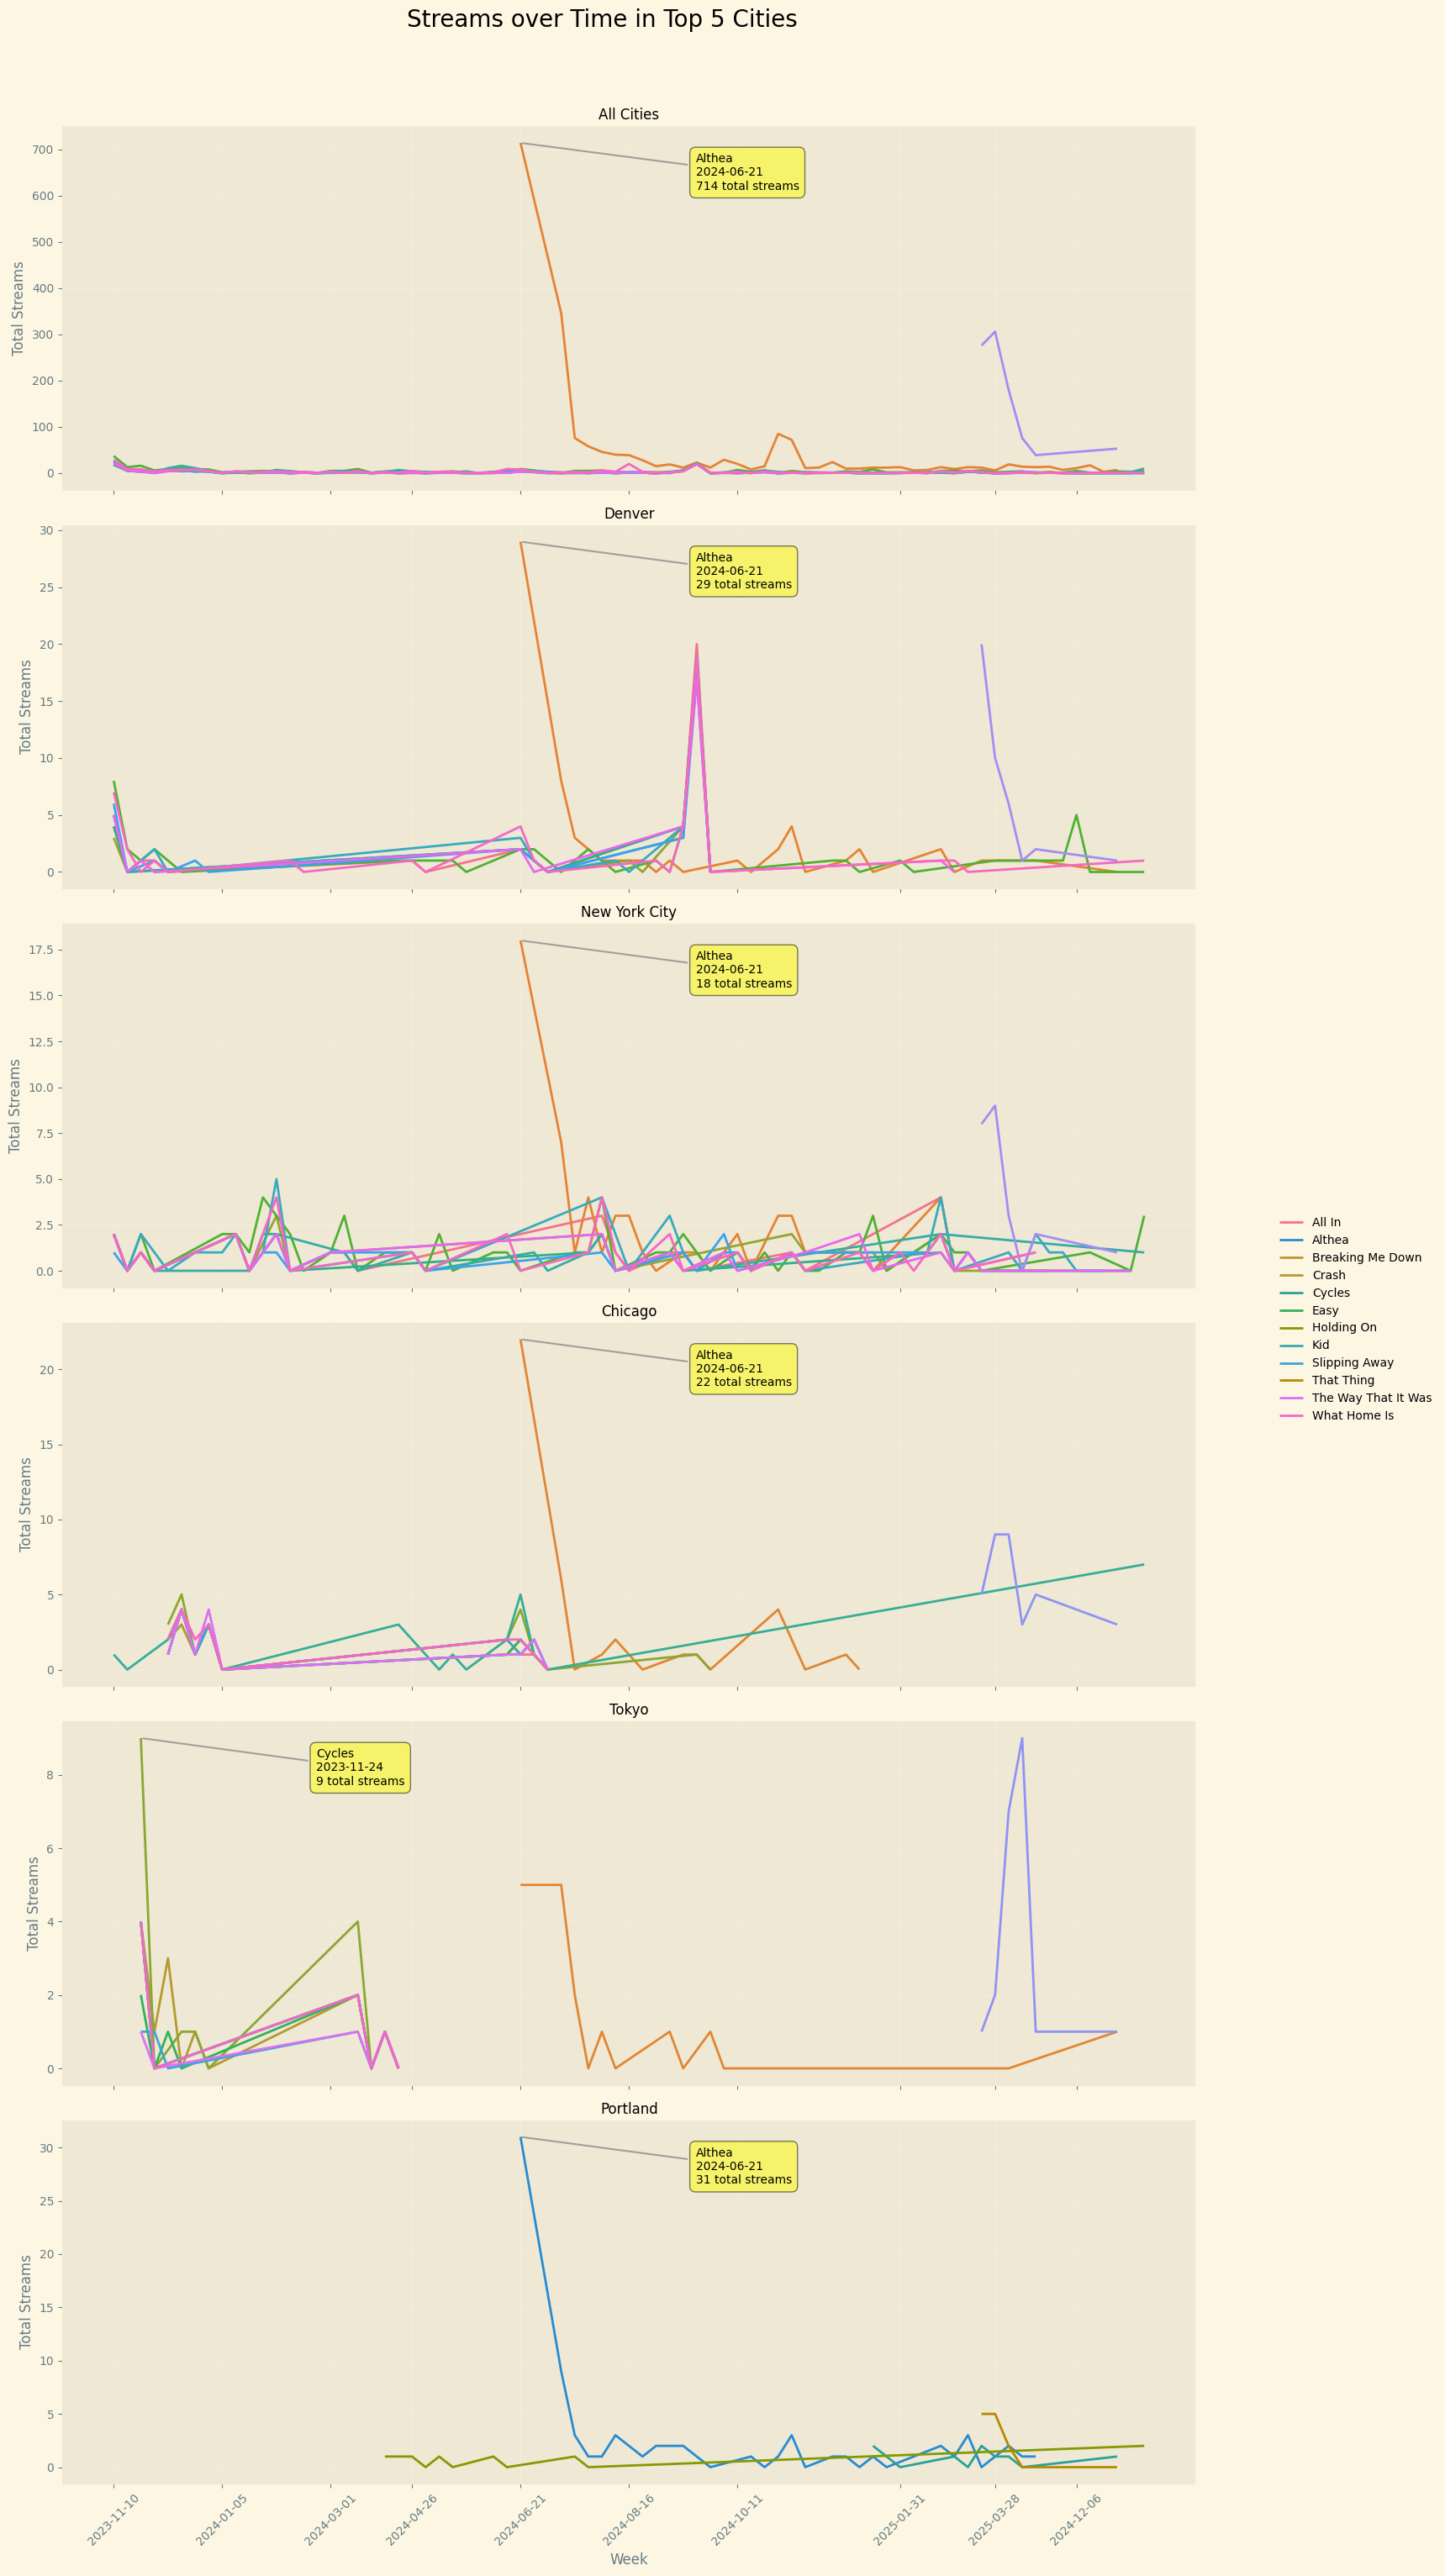

In [10]:
plot_city_trends(data=top_cities_by_song_streams_df, y_column='total_streams', title='Streams over Time in Top 5 Cities')

In [11]:
#top cities by overall streams

query = f"""
SELECT
city, sum(case when a.measure = 'plays' then current_period else 0 end) as total_streams
FROM df a
WHERE 1=1
--AND lower(a.city) like '%new york%'
--AND lower(a.measure) = 'plays'
AND lower(a.song) != 'artist level'
GROUP BY 1
order by 2 desc

"""

top_cities_by_overall_streams = psql.sqldf(query, locals())
top_cities_by_overall_streams.head(6)

,city,total_streams
0,All Cities,4576
1,Denver,425
2,New York City,310
3,Chicago,226
4,Tokyo,106
5,Portland,105


In [12]:
# # City-specific trend lines for each song by listeners

# query = f"""

# SELECT
# a.city
# ,song
# ,week
# ,SUM(current_period) AS weekly_listeners
# FROM df a
#     JOIN
#     (
#         SELECT city, AVG(weekly_listeners) as avg_weekly_listeners
#         FROM
#         (
#         SELECT
#         city
#         ,song
#         ,week
#         ,SUM(current_period) AS weekly_listeners
#         FROM df a
#         WHERE 1=1
#         AND lower(a.measure) = 'listeners'
#         AND lower(a.song) = 'artist level'
#         AND a.period_type = 'weekly'

#         GROUP BY 1, 2, 3
#         )
#         GROUP BY 1
#         ORDER BY 2 DESC
#         LIMIT 6
#     ) b ON a.city = b.city
# WHERE 1=1
# AND lower(a.measure) = 'listeners'
# AND lower(a.song) != 'artist level'
# AND a.period_type = 'weekly'

# GROUP BY 1, 2, 3

# """

# top_cities_by_song_listeners = psql.sqldf(query, locals())
# top_cities_by_song_listeners.head(5)

In [13]:
# plot_city_trends(data=top_cities_by_song_listeners, y_column='weekly_listeners', title='Listeners over Time in Top 5 Cities')

In [14]:
# peak listenership by city

query = f"""

SELECT city, weekly_listeners as max_weekly_listeners, week as peak_week
FROM
(
SELECT *, DENSE_RANK() OVER (PARTITION BY city ORDER BY weekly_listeners DESC
    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as listener_rank
FROM
(
SELECT
city
,week
,SUM(current_period) AS weekly_listeners
FROM df a
WHERE 1=1
AND lower(a.measure) = 'listeners'
AND lower(a.song) = 'artist level'
AND a.period_type = 'weekly'

GROUP BY 1, 2
)
)
WHERE listener_rank =1
ORDER BY max_weekly_listeners DESC

"""

peak_listenership_by_city = psql.sqldf(query, locals())
peak_listenership_by_city.head(6)

,city,max_weekly_listeners,peak_week
0,All Cities,814,2024-06-28 00:00:00.000000
1,Denver,39,2024-06-28 00:00:00.000000
2,Atlanta,25,2024-06-28 00:00:00.000000
3,Seattle,25,2024-06-28 00:00:00.000000
4,Chicago,24,2024-06-28 00:00:00.000000
5,Detroit,24,2024-06-28 00:00:00.000000


In [15]:
# peak streams by city

query = f"""

SELECT city, weekly_plays as max_weekly_plays, week as peak_week
FROM
(
SELECT *, DENSE_RANK() OVER (PARTITION BY city ORDER BY weekly_plays DESC
    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as listener_rank
FROM
(
SELECT
city
,week
,SUM(current_period) AS weekly_plays
FROM df a
WHERE 1=1
AND lower(a.measure) = 'plays'
--AND lower(a.song) = 'artist level'
AND a.period_type = 'weekly'

GROUP BY 1, 2
)
)
WHERE listener_rank =1
ORDER BY max_weekly_plays DESC

"""

peak_stream_week_by_city = psql.sqldf(query, locals())
peak_stream_week_by_city.head(6)

,city,max_weekly_plays,peak_week
0,All Cities,762,2024-06-21 00:00:00.000000
1,Denver,166,2024-09-20 00:00:00.000000
2,Chicago,41,2024-06-21 00:00:00.000000
3,Tokyo,33,2023-11-24 00:00:00.000000
4,Montréal,32,2024-10-25 00:00:00.000000
5,Portland,31,2024-06-21 00:00:00.000000


In [16]:
adoption_results = analyze_adoption_patterns(df)

DataFrame columns: ['city', 'previous_period', 'current_period', '%_change', 'week', 'song', 'song_id', 'measure', 'level', 'grouping', 'period_type']

Analyzing 12 songs

Songs being analyzed:
- All In
- Althea
- Breaking Me Down
- Crash
- Cycles
- Easy
- Holding On
- Kid
- Slipping Away
- That Thing
- The Way That It Was
- What Home Is



=== Metric Explanations ===

Consistency Score:
• Calculated as: (Number of Active Weeks / Total Weeks Since First Activity) × 100
• Active Week: A week where the song had any streams
• Higher scores indicate more consistent engagement over time
• Example: A score of 75% means the city was active 75% of the weeks since they first played the song

Weeks to Adopt:
• Measures how quickly a city starts playing a song after its release
• Calculated as: (First Activity Date - Song Release Date) in weeks
• Lower numbers indicate faster adoption
• Example: 2.5 weeks means the city started playing the song 2.5 weeks after release

Note: Analysis excludes cities with fewer than 50 lifetime streams

=== City Categories Overview ===

Category Statistics:
              total_streams total_listeners consistency_score weeks_to_adopt  \
category                                                                       
Early Adopter           196             231             42.5%            0.0   
Late B

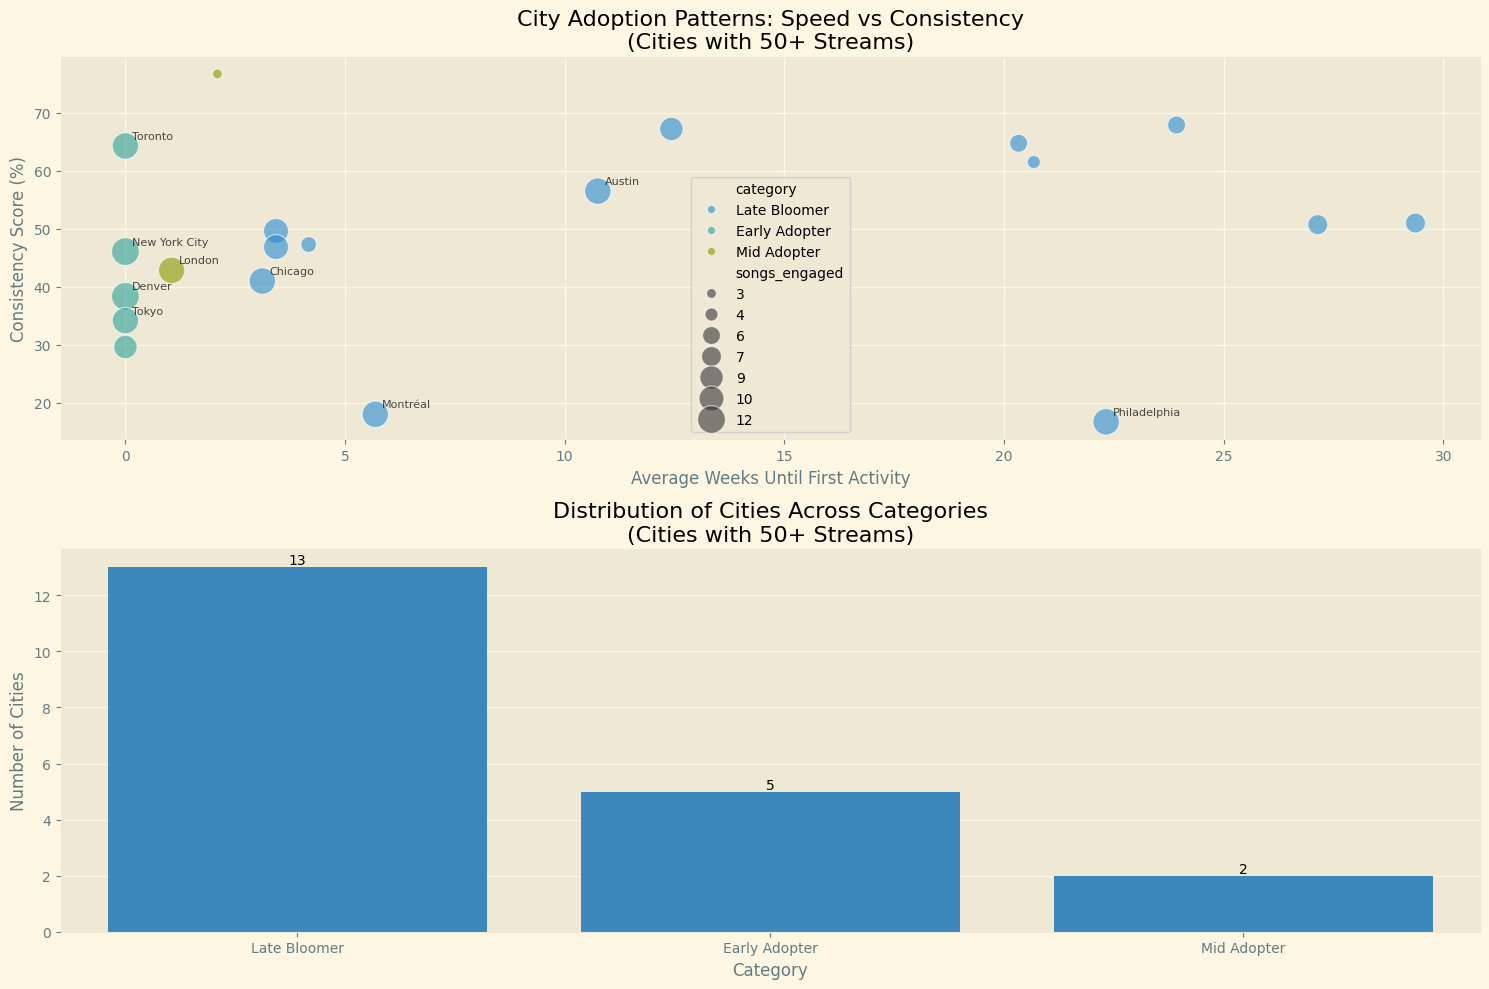


=== Song Adoption Statistics ===

Top 5 Most Widely Adopted Songs (In Cities with 50+ Streams):
      song  avg_weeks_to_adopt avg_consistency  num_cities
That Thing                0.00           65.7%          20
    Althea                0.00           50.5%          20
    Cycles                8.38           30.2%          19
Holding On                8.40           41.2%          17
    All In               12.14           38.3%          17


In [17]:
display_adoption_results(adoption_results)